CE310 Evolutionary Computation and Genetic Programming<br>
Reinhold Scherer, Spring 2022
### Assignment: Programming Assignment and mini project Part 2 (of 2) – Mini project
### Genetic Programming and Symbolic Regression
For information on on symbolic regression see the learning material on Moodle or visit: 
https://en.wikipedia.org/wiki/Symbolic_regression

In [ ]:
# Install DEAP toolbox
# https://deap.readthedocs.io/en/master/index.html

# Anaconda:
# easy_install deap

# Google Colab:
# !pip install deap

In [1]:
# Import relevant Python modules
import operator
import math
import random
import numpy  as np
from matplotlib import pyplot

# Import DEAP modules
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

## Experiment 1: Function f(x) = 5*x^5 + 4*x^4 + 3*x^3 + 2*x^2 + x

### Parameters:
1. Number of Generations
2. Number of offsprings selected for crossover

In [158]:
# ====================================================================
# PARAMETERS - change the parameters in this section
# Population size: 500 vs 2000
# Tournament Size: 2 vs 5
# repeat at least 10 times per setting

no_generations = 50   # number of generations
no_population = 2000   # population size
no_tournaments =  5   # tournament size

# other parameters that you can change and explore
p_xo = 0.7  # XO rate
p_m  = 0.3  # Mutation rate
UseSqError = True # use Least Squares approach 

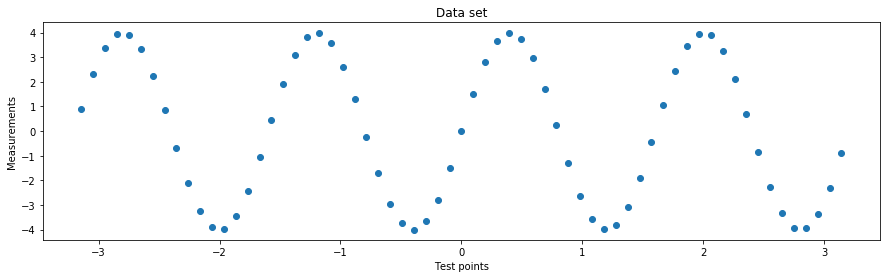

In [159]:

# ====================================================================
# Define your Problems/Target Functions and create sample data
# Assume you make measurments at specific test points:

test_points = np.linspace(-math.pi,math.pi, 65).tolist()
measurement = lambda x: 4 * math.sin(((5*math.pi)/4)*x)

# ====================================================================

target = np.empty(len(test_points))
for i in range(len(test_points)):
    target[i] = measurement(test_points[i])

fig, ax = pyplot.subplots(figsize=(15,4))
ax.scatter(test_points, target)
ax.set_xlabel('Test points')
ax.set_ylabel('Measurements')
ax.set_title('Data set')
pyplot.show()

# GP Goal: evolve a function f(x) (mathematical expression or model) with 
# x=test_points that best fits a target dataset

Change code to put away sin and cosine sqrt can be represented as multiplication twice therefore we dont need add sqrt

In [160]:
# Define new functions
def protectedDiv(left, right):
    return left / right if right else 1    
    
# create Primitive set & classes 
if "pset" not in globals():
    pset = gp.PrimitiveSet("MAIN", 1)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)
    pset.addTerminal(1)
    pset.addTerminal(-1)    
    pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
    pset.renameArguments(ARG0='x')

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
    
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


def evalSymbReg(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)

    if UseSqError:
      # squared error
      error = (abs(func(x) - measurement(x))**2 for x in test_points)    
    else:
      # Absolute distance between target curve and solution
      error = (abs(func(x) - measurement(x)) for x in test_points)    

    return math.fsum(error)/len(test_points),


toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=no_tournaments)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=64))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=64))

random.seed()

pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("mdn", np.median)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, p_xo, p_m, no_generations, stats=mstats,
                                       halloffame=hof, verbose=True)

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min    	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	3.37115e+28	0  	2.23002e+31	9.02394	7.78394	2000  	7.61951e+29	3.592	0  	7  	3  	2  	2000  	1.53021
1  	1583  	5.76619e+27	1  	8.20644e+30	8.53163	7.6311 	1583  	1.97916e+29	3.706	1  	13 	3  	1  	1583  	1.94025
2  	1616  	1.04238e+28	2  	2.02486e+31	8.31586	7.6311 	1616  	4.5285e+29 	4.213	2  	16 	4  	1  	1616  	2.16509
3  	1606  	1.62791e+28	3  	2.02486e+31	8.02394	7.6311 	1606  	4.9168e+29 	4.664	3  	16 	4  	1  	1606  	2.41808
4  	1596  	1.93565e+28	4  	2.02486e+31	8.02394	7.37693	1596  	5.23525e+29	5.159	4  	19 	5  	1  	1596  	2.78778
5  	1562  	2.37662e+28	5  	2.02486e+31	8.02394	7

Fitnes: [2.372623853314154, 9.023935652480555]
Size: [3.0, 176.0]
Evaluations: 81389


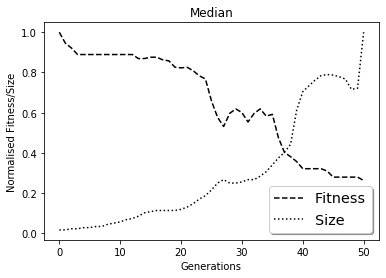

In [161]:
# Plot Fitness and Size
x = np.arange(0, no_generations+1)
s = log.chapters['size'].select("mdn")
f = log.chapters['fitness'].select("mdn")

fig, ax = pyplot.subplots()
ax.plot(x, f/max(f), 'k--', label='Fitness')
ax.plot(x, s/max(s), 'k:', label='Size')
ax.set_xlabel('Generations')
ax.set_ylabel('Normalised Fitness/Size')
ax.set_title('Median')
legend = ax.legend(shadow=True, fontsize='x-large')
print('Fitnes: [' + str(min(f))+', '+str(max(f))+']')
print('Size: [' + str(min(s))+', '+str(max(s))+']')
print('Evaluations: ' +str(sum(log.select("nevals"))))

pyplot.show()

In [162]:
# Best individual 
print(hof[0])

protectedDiv(cos(protectedDiv(sub(mul(sub(x, protectedDiv(sub(cos(cos(x)), 1), protectedDiv(protectedDiv(x, -1), protectedDiv(1, 1)))), mul(x, -1)), -1), protectedDiv(1, -1))), protectedDiv(x, sub(mul(sub(sub(x, mul(mul(cos(protectedDiv(cos(x), mul(-1, -1))), x), -1)), protectedDiv(x, -1)), mul(mul(cos(protectedDiv(cos(protectedDiv(x, -1)), mul(-1, -1))), x), -1)), sub(-1, 1))))


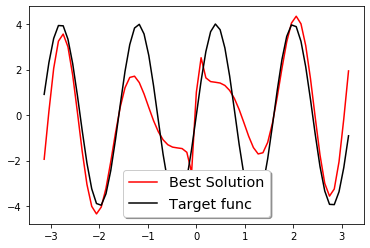

In [163]:
# Plot comparison Tagret vs. evolved solution

x = test_points
f = toolbox.compile(expr=hof[0])

y = np.empty(len(x))
for i in range(len(x)): y[i] = f(x[i])

fig, ax = pyplot.subplots()
ax.plot(x, y, 'r-', label='Best Solution')
ax.plot(x, target, 'k-', label='Target func')
#legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
legend = ax.legend(shadow=True, fontsize='x-large')

pyplot.show()

## Experiment 1, 2, 3, 4 : Function f(x) = 5*x^5 + 4*x^4 + 3*x^3 + 2*x^2 + x

### Initial Function:
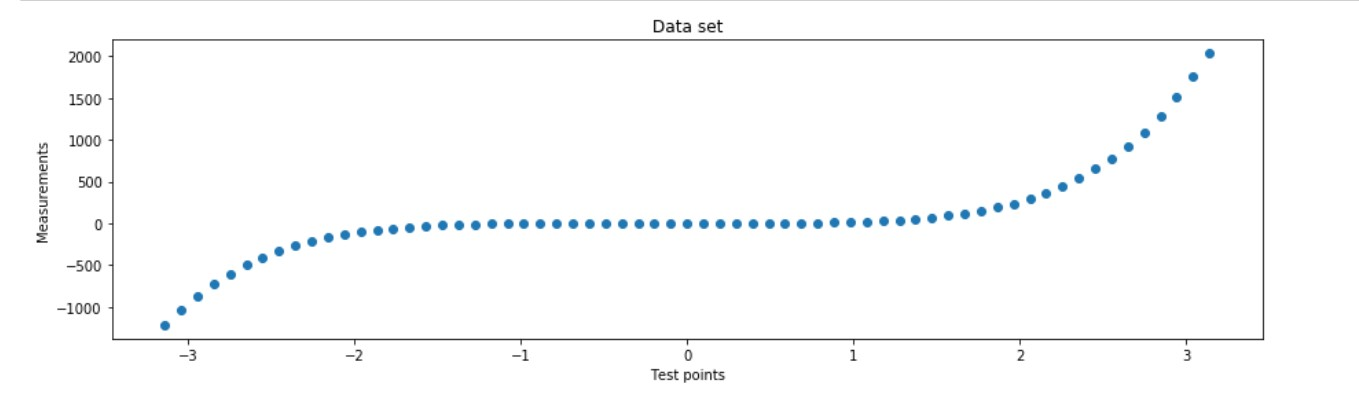

### Parameters into the system: 
   #### Option 1 
    
    1. no_population = 500
    2. no_tournaments = 2
    
   #### Option 2
    
    1. no_population = 2000
    2. no_tournaments = 2
    
   #### Option 3
    
    1. no_population = 500
    2. no_tournaments = 5
    
   #### Option 4
    
    1. no_population = 2000
    2. no_tournaments = 5
    
### Primitives to constract solution:
    1. Addition - +
    2. Subtraction
    3. Multiplication
    4. Division
    5. Negotiation-
    6. Sin
    7. Cos
 
 ## Analysis
 
 #### Option 1: no_population = 500, no_tournaments = 2
 
   ##### Result, trial 1:
    
   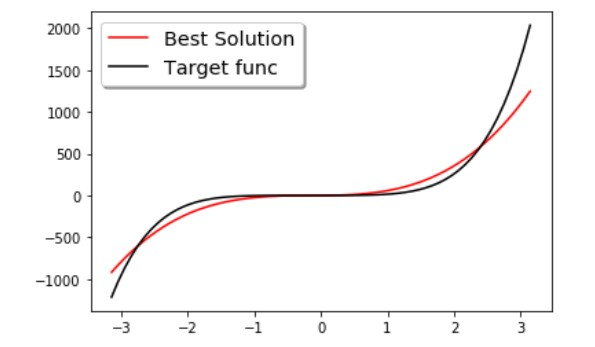
   
   ##### Result, trial 2
   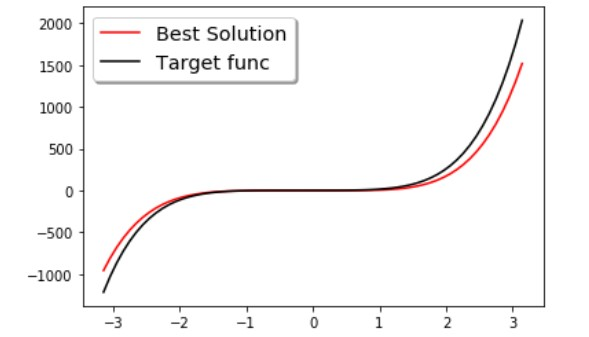
   
   ##### Efficiency graph
   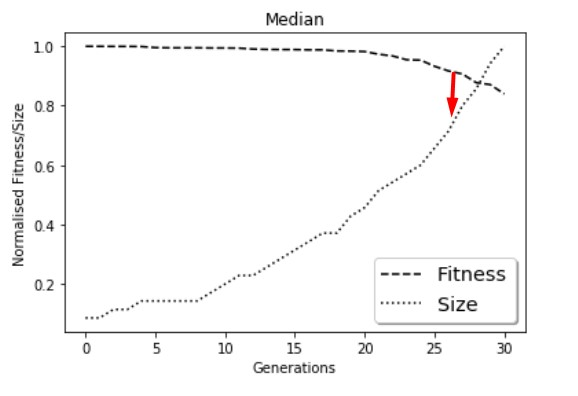
  
  As we see from the diagram, fitness of an program start decreases (we are trying to minimise it) after 25 generation (when size of operators reach certain point when it is able to constarct solution which is relevant to a problem)
  In case ofnumber of tournament pool = 2, it is happpening after 25 generations. Therefore,we can make observation and assumption number 1 that amount of operators correlate with fitness value
  
  
 #### Option 2: no_population = 2000, no_tournaments = 2
    
   ##### Efficiency graph
   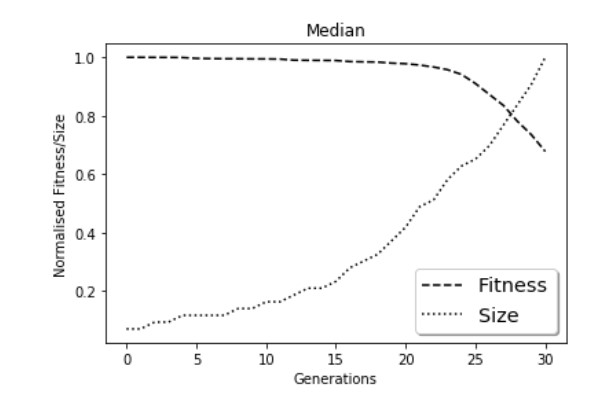
     
  As we see from the diagram, fitness of an program start decreases faster than in case of option 1 after 22 generation due t change in population size. It is happening propably because program have wider pool of options to take from, this observation represent that it is relevant to play with population pool for some type of problems
  
  
 #### Option 3: no_population = 500 no_tournaments = 5
 
 ##### Result, trial 1:
 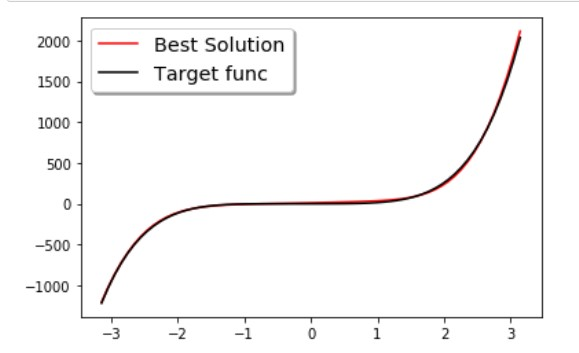

 ##### Efficiency graph
  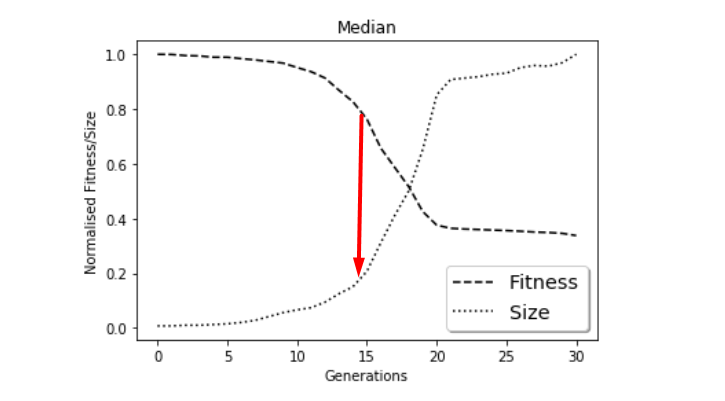
 We increases tournament size till 5 (tournament size represent amount of "parents" compited witch each other to create offspring for next generation). As we can see from a diagram due to this change fitness value of generation start to decreases much more earlier, about 15 generation , it is approximately 65% faster than in Option 1 when tournament size was 2, therefore it is give us evidance that assumption number 1 is not represent all picture and can be false. We can make new observation and assumption that number of tournament pool size is correlate with a speed of finding appropriate solution inside a generation for a problem.
 
 #### Option 4: no_population = 2000 no_tournaments = 5
  
  ##### Result, trial 1:
  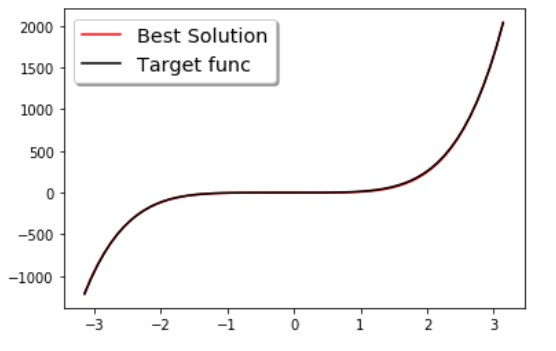
 
 
  ##### Efficiency graph
  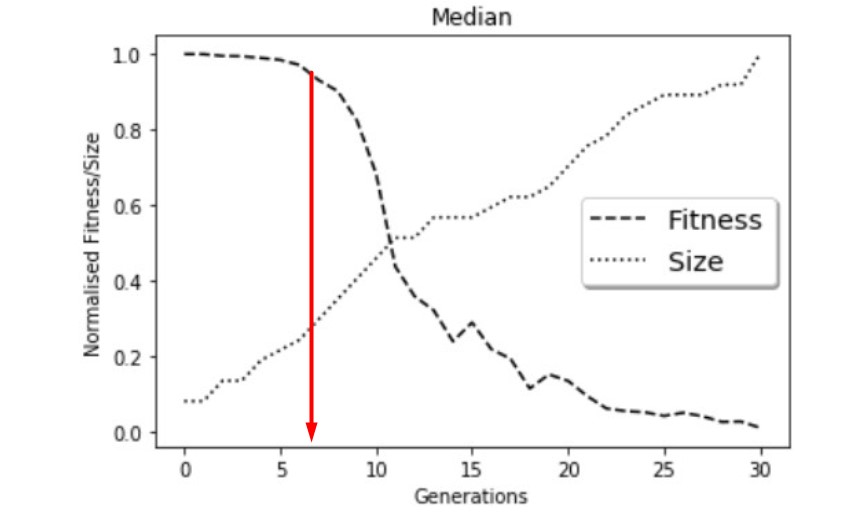
  
  This combination represent best and most efficient solution for this problem. Fitness function start to decreases at 6-7 generation, which is approximetly 50% faster than in option 3 and fitness value of last generation come closer to 0.1 which is very good result and nearly close to global solution
  
  
  ## Experiment 5, 6, 7, 8 : Function f(x) = 4 * math.sin(((5*math.pi)/4)*x)
  
  ### Initial Function:
  
  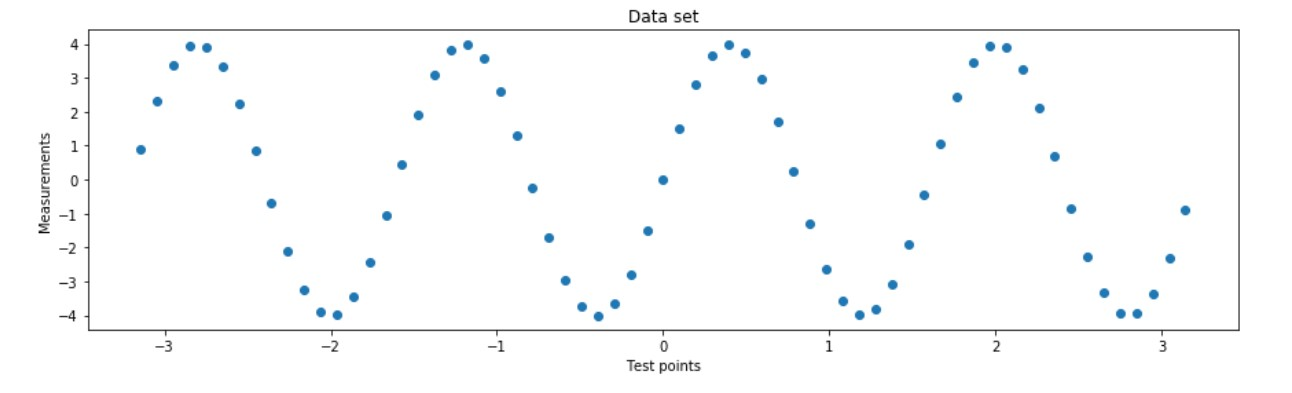
  
  ### Parameters into the system: 
   #### Option 1 
    
    1. no_population = 500
    2. no_tournaments = 2
    
   #### Option 2
    
    1. no_population = 2000
    2. no_tournaments = 2
    
   #### Option 3
    
    1. no_population = 500
    2. no_tournaments = 5
    
   #### Option 4
    
    1. no_population = 2000
    2. no_tournaments = 5
    
    
   ### Primitives to constract solution:
    1. Addition - +
    2. Subtraction
    3. Multiplication
    4. Division
    5. Negotiation-
    6. Sin
    7. Cos
 
  ## Analysis
 
 #### Option 1: no_population = 500, no_tournaments = 2
 
  We can see from the beginning that this propblem is much more harder for GP to find closer solution. we can see that at initial setup GA stuck on stagnation period closer to 0.9 efficiency
 
 ##### Result, trial 1:
 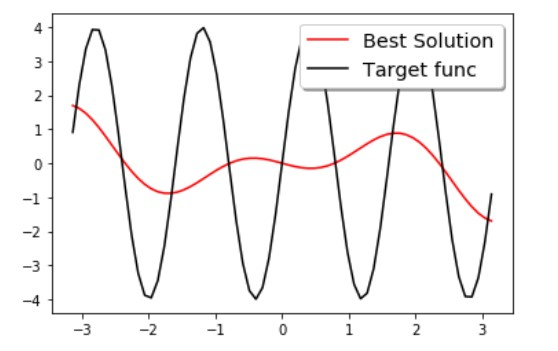
 
 ##### Efficiency graph
 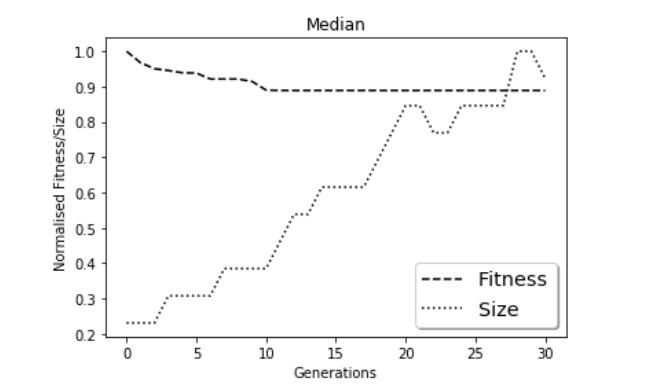
 
 
  #### Option 2: no_population = 2000, no_tournaments = 2
   We can see slight improvement in GA efficiency from 0.9 to 0.85 from increasing no_population, this problem is also give evidance that increase in no_population, improve overall efficiency of a system 
   
 ##### Result, trial 1:
 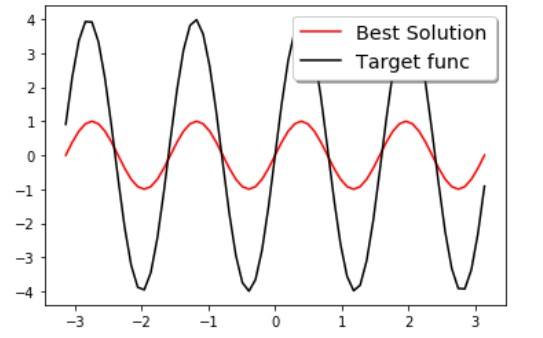
 
 ##### Efficiency graph
 !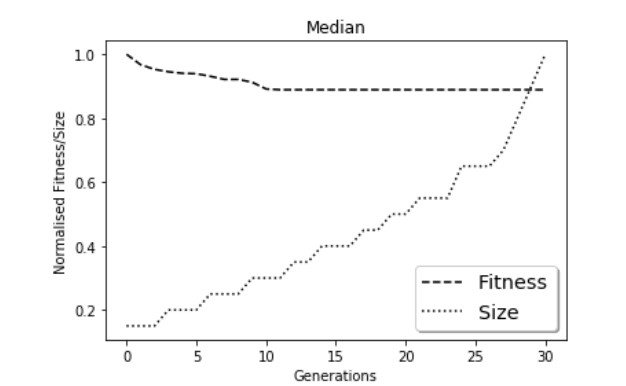
 
  #### Option 3: no_population = 500 no_tournaments = 5
  Overall, we can see that increase in no_tournaments from 2 to 5, decrease amount of stagnation episode during evalution of a system and add dynamism to possible solutions
  
  ##### Result, trial 1:
 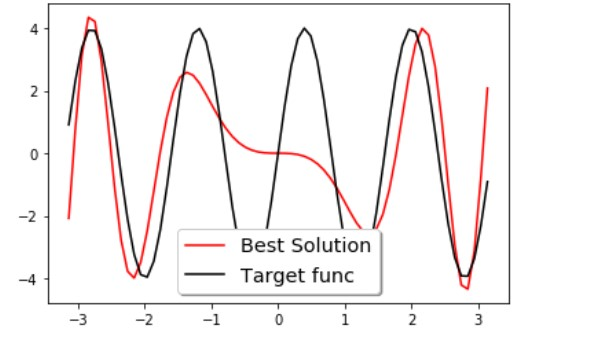
 
 ##### Efficiency graph
 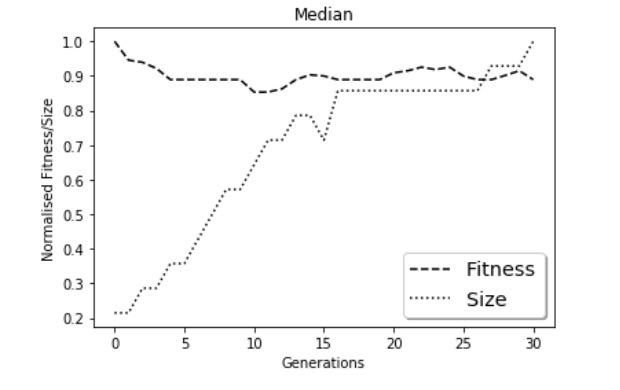
 
 #### Option 4: no_population = 2000 no_tournaments = 5
 Combination of increase in this 2 parameters dramaticaly increases overall productivity of a system, It is happening propably because no_population increases possible pool of solutions with wich GP is working bet no_tournaments add dynamism to recombinations of this solutions. I can make assumption that after increasing number of generations system wil produce much more closer to real function result due to fact that no_population and no_tournaments is working in symbios with each other
 
 ##### Result, trial 1:
 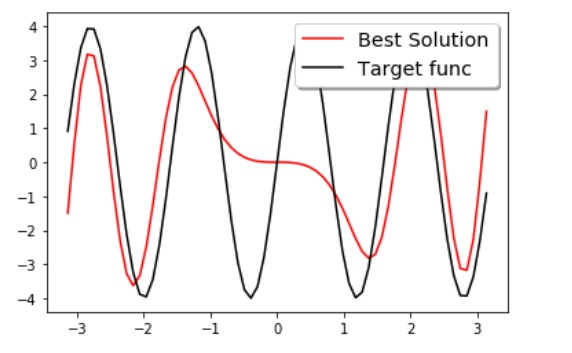
 
 ##### Efficiency graph
 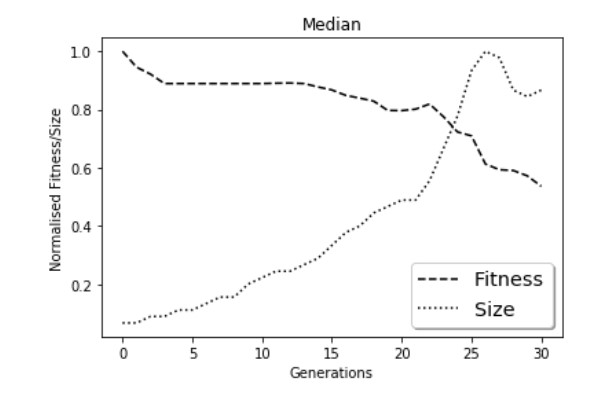
 
  #### Option 5: no_population = 2000 no_tournaments = 5 no_generations = 50 
  
  Assumption from Option 4 is confirmed data is show that increase in no_tournaments and  no_generations together will increase result even for much more complicated problems. It give as evidance that no_tournaments and no_generations has symbios
  
  ##### Result, trial 1:
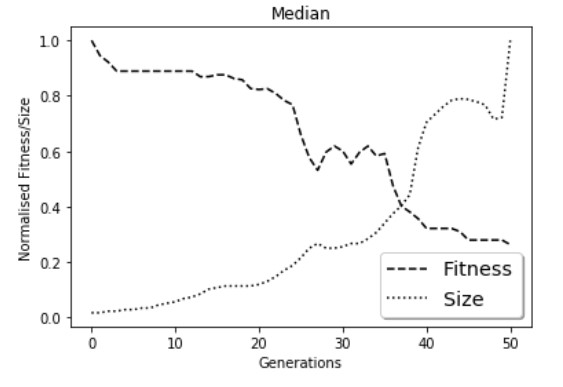
 
 ##### Efficiency graph
 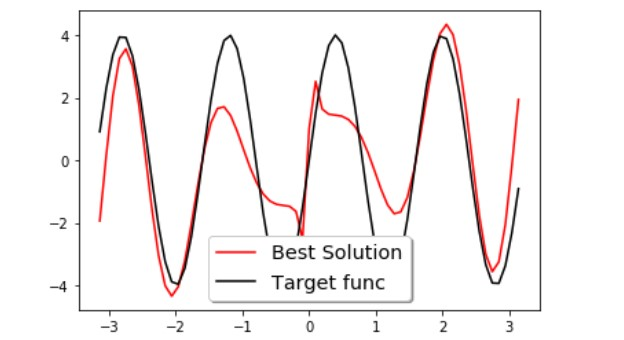
 
 
 ## Conclusion from experiment 
 
 Experiment 1, 2, 3, 4, 5, 6, 7, 8 show evidance that increase in size of population slightly increase efficiency and increase in tournament size increase efficiency much more than increase in size of population, bet increase in both together create positive symbios effect which improve overall performance of GP system
 